In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random as rd

sys.path.append("..")

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import HenonHeiles_Methods as hh

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [2]:
Ename = "01"

x, y = hh.read_dataset('x_train_'+ Ename +'.txt', 'y_train_'+ Ename +'.txt')

train_dataset, val_dataset = hh.train_dataset(x[:300], y[:300], 30, 270, 30) # val_len, train_batch, val_batch

Number of points:  765


In [3]:
model1N2 = rs.SympNet(30, 8, 'non_reversible')

In [4]:
# DECAYING LEARNING RATE
def scheduler(epoch, lr):
    if epoch%100==0:
        print("epoch: ", epoch)
    if epoch < 5:
        return lr
    else:
        return lr*tf.math.exp(-0.0007)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [5]:
checkpoint_path_1N2 = "checkpoints_SN_PP_1N2_008/cp.ckpt"
checkpoint_dir_1N2 = os.path.dirname(checkpoint_path_1N2)

In [6]:
cp_callback_1N2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_1N2,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=0)

In [7]:
model1N2.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=["accuracy"],
)

In [8]:
Epochs = 3000

history1N2 = model1N2.fit(train_dataset, epochs = Epochs, validation_data=val_dataset, callbacks=[callback, cp_callback_1N2], verbose=0)

epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900


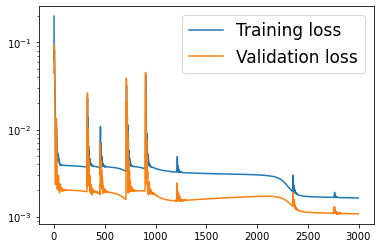

In [9]:
plt.plot(history1N2.history["loss"], label="Training loss")
plt.plot(history1N2.history["val_loss"], label="Validation loss")
plt.yscale("log")
plt.legend(fontsize=17)
plt.show()

In [ ]:
f = open("HM_NN_Loss.txt", "a")
for i in history1N2.history["loss"]:
        f.write(str(i))
        f.write("\n")
f.close()

f = open("HM_NN_Val.txt", "a")
for i in history1N2.history["val_loss"]:
        f.write(str(i))
        f.write("\n")
f.close()

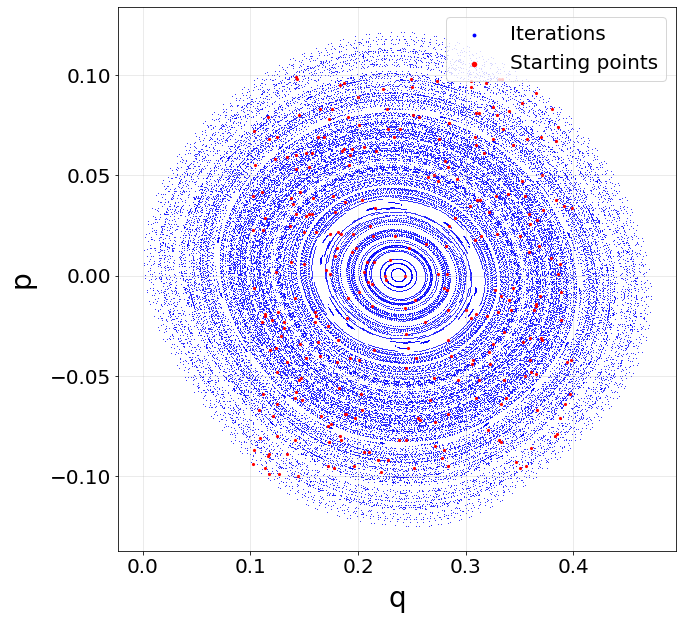

In [10]:
N = 300
x0 = np.array([[rd.randrange(100, 400, 1)*0.001, rd.randrange(-100, 100, 1)*0.001] for _ in range(N)])
iterations = [model1N2(x0)]
for _ in range(200):
    iterations.append(model1N2(iterations[-1]))
    
plt.figure(figsize=(10,10))
colors = []
sizes = []
for i in range(N):
    if i==18:
        colors.append("r")
        sizes.append(10)
    else:
        colors.append("b")
        sizes.append(1)

plt.scatter(*zip(*iterations[0].numpy()), s=1, linewidth=0, color="b", label = "Iterations")

        
for i in iterations:
    plt.scatter(*zip(*i.numpy()), s=1, linewidth=0, color="b")
    
plt.scatter(*zip(*x0), s=10, linewidth=0, color="r", label = "Starting points")


plt.xlabel("q", fontsize=28, labelpad=8)
plt.ylabel("p", fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=20)
lgnd.legendHandles[0]._sizes = [15]
lgnd.legendHandles[1]._sizes = [30]
plt.show()